# Loading data - Section 1

In [1]:
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os
import random

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = os.listdir(os.path.join(folder_path, "Images"))
        self.mask_files = os.listdir(os.path.join(folder_path, "Masks"))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, "Images", self.image_files[idx])
        mask_name = os.path.join(self.folder_path, "Masks", self.mask_files[idx])

        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask




data_folder = "./Data/"
custom_dataset = CustomDataset(data_folder, transform=None)
batch_size = 4

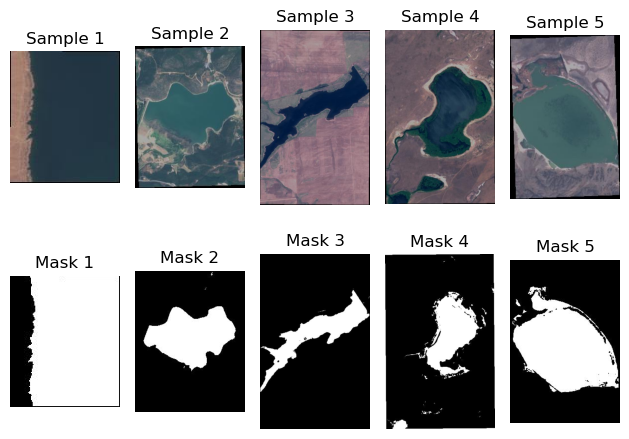

In [2]:
import matplotlib.pyplot as plt
import random


num_samples_to_display = 5
fig, (ax1, ax2) = plt.subplots(2, num_samples_to_display)


random_indices = random.sample(range(len(custom_dataset)), num_samples_to_display)

for i, idx in enumerate(random_indices):
    image, mask = custom_dataset[idx]

    # Plot image
    ax1[i].imshow(image)
    ax1[i].axis('off')
    ax1[i].set_title(f"Sample {i + 1}")

    # Plot mask
    ax2[i].imshow(mask, cmap='gray')
    ax2[i].axis('off')
    ax2[i].set_title(f"Mask {i + 1}")

plt.tight_layout()
plt.show()


In [3]:
import numpy as np
def get_bounding_box(ground_truth_map):
  # gray_map = np.array(Image.fromarray(ground_truth_map).convert('L'))

  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  H, W = ground_truth_map.shape
  # x_min = max(0, x_min - np.random.randint(0, 20))
  # x_max = min(W, x_max + np.random.randint(0, 20))
  # y_min = max(0, y_min - np.random.randint(0, 20))
  # y_max = min(H, y_max + np.random.randint(0, 20))
  x_min = max(0, x_min)
  x_max = min(W, x_max)
  y_min = max(0, y_min)
  y_max = min(H, y_max)
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [4]:
import numpy as np
from torch.utils.data import Dataset
class SAMDataset(Dataset):
    def __init__(self, folder_path, processor=None):
        self.folder_path = folder_path
        self.image_files = os.listdir(os.path.join(folder_path, "Images"))
        self.mask_files = os.listdir(os.path.join(folder_path, "Masks"))
        self.processor = processor

        # self.image_transform = transforms.Compose([
        #     transforms.Resize((256, 256), interpolation=Image.NEAREST)
        # ])
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, "Images", self.image_files[idx])
        mask_name = os.path.join(self.folder_path, "Masks", self.mask_files[idx])
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("L")
        # image_transfromed = self.image_transform(image)
        prompt = get_bounding_box(np.array(mask))
        mask_transformed = self.mask_transform(mask)
        ground_truth_mask = np.array(mask_transformed)

        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask



        return inputs


In [5]:

from transformers import SamProcessor
data_folder = "./Data/"
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# processor.image_processor.do_normalize = False
# processor.image_processor.do_pad = False
# processor.image_processor.do_rescale = False
# processor.image_processor.do_resize = False

sam_dataset = SAMDataset(folder_path=data_folder, processor=processor)


In [6]:

processor

SamProcessor:
- image_processor: SamImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


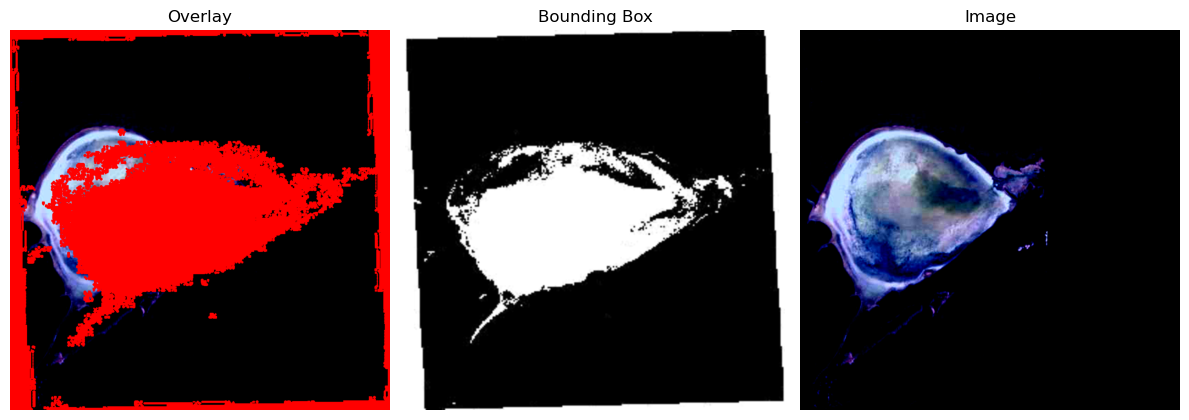

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

data = sam_dataset[3]  

image = data['pixel_values']  
bounding_box = data['ground_truth_mask']  
image = np.transpose(image, (1, 2, 0))
resized_bounding_box = cv2.resize(bounding_box, (image.shape[1], image.shape[0]))

image_with_overlay = np.copy(image)

image_with_overlay[resized_bounding_box > 0] = [255, 0, 0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

ax1.imshow(image_with_overlay)
ax1.set_title('Overlay')
ax1.axis('off')

ax2.imshow(resized_bounding_box, cmap='gray')
ax2.set_title('Bounding Box')
ax2.axis('off')

ax3.imshow(image)
ax3.set_title('Image')
ax3.axis('off')

plt.tight_layout()
plt.show()


In [8]:
example = sam_dataset[0]
for k,v in example.items():
  if type(v) != str and type(v) != list :
    print(k,v.shape)
  

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [9]:
from torch.utils.data import Subset, DataLoader, random_split
import numpy as np



dataset_size = len(sam_dataset)
train_size = int(0.9 * dataset_size)
val_size = dataset_size - train_size

indices = list(range(dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[:train_size], indices[train_size:]
# train_indices, val_indices = indices[:300], indices[301:350]

train_dataset = Subset(sam_dataset, train_indices)
val_dataset = Subset(sam_dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)


In [10]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
    if type(v) != str and type(v) != list :

      print(k,v.shape)
     

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


# Load Sam - Section 2

In [11]:

from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
     

# Augmentation - Section 3

# Metrics, Optimizer, Cost function - Section 4

In [12]:
import numpy as np

def dice_coefficient(prediction, target):
    prediction = prediction.flatten()
    target = target.flatten()
    
    intersection = np.sum(prediction * target)
    dice = (2. * intersection) / (np.sum(prediction) + np.sum(target))
    
    return dice

def iou_score(prediction, target):
    intersection = np.sum(prediction * target)
    union = np.sum(prediction) + np.sum(target) - intersection
    
    iou = intersection / (union + 1e-8)  # Adding a small value to prevent division by zero
    
    return iou



In [13]:
from torch.optim import AdamW
import monai

optim = AdamW(model.mask_decoder.parameters(), lr=1e-3)
seg_loss = torch.nn.MSELoss()


# Fine-Tuning

In [14]:
import numpy as np
import torch
from tqdm import tqdm

num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_dice = []
    epoch_iou = []
    model.train()
    for batch in tqdm(train_dataloader):
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        predicted_masks_probs = torch.sigmoid(predicted_masks)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        predicted_masks = (predicted_masks > 0.5).float()

        dice = dice_coefficient(predicted_masks.flatten().cpu().detach().numpy() ,
                                ground_truth_masks.flatten().cpu().detach().numpy() )
        iou = iou_score(predicted_masks.flatten().cpu().detach().numpy() ,
                        ground_truth_masks.flatten().cpu().detach().numpy() )

        epoch_losses.append(loss.item())
        epoch_dice.append(dice)
        epoch_iou.append(iou)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

    model.eval() 
    validation_losses = []
    validation_dice = []
    validation_iou = []

    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        
            predicted_masks = torch.sigmoid(predicted_masks)
            loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

            predicted_masks = (predicted_masks > 0.5).float()

            dice = dice_coefficient(predicted_masks.flatten().cpu().detach().numpy() ,
                                    ground_truth_masks.flatten().cpu().detach().numpy() )
            iou = iou_score(predicted_masks.flatten().cpu().detach().numpy() ,
                            ground_truth_masks.flatten().cpu().detach().numpy() )

            validation_losses.append(loss.item())
            validation_dice.append(dice)
            validation_iou.append(iou)

    print(f'EPOCH: {epoch}')
    print(f'Train loss: {np.mean(epoch_losses)}')
    print(f'Validation Loss: {np.mean(validation_losses)}')
    print(f'Train Dice Coefficient: {np.mean(epoch_dice)}')
    print(f'Validation Dice Coefficient: {np.mean(validation_dice)}')
    print(f'Train IoU: {np.mean(epoch_iou)}')
    print(f'Validation IoU: {np.mean(validation_iou)}')


100%|██████████| 143/143 [00:46<00:00,  3.05it/s]


EPOCH: 0
Train loss: 13471.864110716819
Validation Loss: 19061.979388043597
Train Dice Coefficient: 1.9669241489620592
Validation Dice Coefficient: 1.9624610079733618
Train IoU: 84.67369685570002
Validation IoU: 76.00947536314256


100%|██████████| 143/143 [00:46<00:00,  3.05it/s]


EPOCH: 1
Train loss: 12156.085451129084
Validation Loss: 19242.959679236777
Train Dice Coefficient: 1.967016753977648
Validation Dice Coefficient: 1.9650095529809868
Train IoU: 83.57030624537914
Validation IoU: 76.31665248692146


100%|██████████| 143/143 [00:46<00:00,  3.05it/s]


EPOCH: 2
Train loss: 11725.346291125661
Validation Loss: 19118.062583656578
Train Dice Coefficient: 1.9679756561920705
Validation Dice Coefficient: 1.9656345068762797
Train IoU: 83.71754580583436
Validation IoU: 75.18320200415853


100%|██████████| 143/143 [00:47<00:00,  3.04it/s]


EPOCH: 3
Train loss: 12425.786439612064
Validation Loss: 19077.40414322006
Train Dice Coefficient: 1.9668780663487824
Validation Dice Coefficient: 1.964052664871819
Train IoU: 83.81108110556927
Validation IoU: 76.07113693807032


100%|██████████| 143/143 [00:46<00:00,  3.05it/s]

EPOCH: 4
Train loss: 12987.867918775675
Validation Loss: 19073.848217944163
Train Dice Coefficient: 1.9684371462865482
Validation Dice Coefficient: 1.964825838779811
Train IoU: 84.79108026272287
Validation IoU: 76.05590772294751


# Feed-forward

In [15]:
mask = Image.open("./Data/Masks/water_body_8941.jpg").convert('L')
image = Image.open("./Data/Images/water_body_8941.jpg").convert('RGB')

ground_truth_mask = np.array(mask)
prompt = get_bounding_box(ground_truth_mask)

inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to("cuda")
for k,v in inputs.items():
  print(k,v.shape)
model.to("cuda")

model.eval()


with torch.no_grad():
  outputs = model(pixel_values=inputs["pixel_values"].to(device),
                          input_boxes=inputs["input_boxes"].to(device),
                          multimask_output=False)

# with torch.no_grad():
#   outputs = model(**inputs, multimask_output=False)
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [16]:
medsam_seg.shape

(256, 256)

In [17]:
image.size[0]

249

(328, 249, 3)
(328, 249, 3)


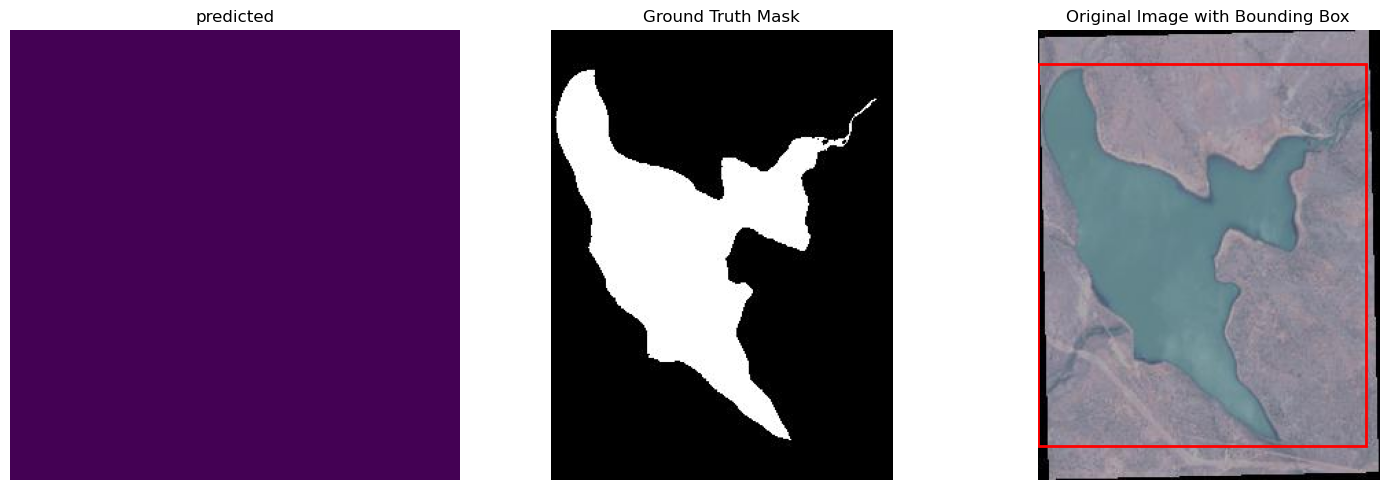

In [18]:
from matplotlib.patches import Rectangle


def show_mask_with_rectangle(image, ax, bounding_box=None):
    print(image.shape)
    h, w = image.shape[-2:]
    image = image
    print(image.shape)
    ax.imshow(image)

    if bounding_box is not None:
        x_min, y_min, x_max, y_max = bounding_box

        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=2, edgecolor='red', facecolor='none')

        ax.add_patch(rect)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(medsam_seg)
axes[0].set_title('predicted')
axes[0].axis("off")


axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis("off")

axes[2].imshow(np.array(image))
show_mask_with_rectangle(np.array(image), axes[2], bounding_box=prompt)
axes[2].set_title('Original Image with Bounding Box')
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [19]:
image.size

(249, 328)

In [20]:
medsam_seg

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [21]:
image.resize((256, 256)).size

(256, 256)